In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import zipfile
import random
import shutil
from sklearn.model_selection import train_test_split

zip_path = '/content/drive/MyDrive/_Diabetic Retinopathy Dataset 2023.zip'
extract_path = '/content/retinopathy_dataset'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define base directories for splits
base_dir = '/content/retinopathy_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create directories if they don't exist
for directory in [train_dir, val_dir, test_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Define class labels
classes = ['0', '1', '2', '3', '4']

# Create subdirectories for each class in train/val/test
for c in classes:
    for split in [train_dir, val_dir, test_dir]:
        os.makedirs(os.path.join(split, c), exist_ok=True)

# Split and copy images into train, val, and test folders
for c in classes:
    class_dir = os.path.join(extract_path, c)
    images = os.listdir(class_dir)
    random.shuffle(images)

    train_split = int(0.7 * len(images))
    val_split = int(0.85 * len(images))

    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]

    for img in train_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(train_dir, c, img))
    for img in val_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(val_dir, c, img))
    for img in test_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(test_dir, c, img))

print("Data successfully split ✅")


Data successfully split ✅


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import copy
import os

# Setting up transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loading data
train_data = datasets.ImageFolder(root='/content/retinopathy_split/train', transform=train_transform)
val_data = datasets.ImageFolder(root='/content/retinopathy_split/val', transform=test_val_transform)
test_data = datasets.ImageFolder(root='/content/retinopathy_split/test', transform=test_val_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Loading ResNet34
model = models.resnet34(pretrained=True)

# Freezing all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreezing the last block (layer4) + fc
for param in model.layer4.parameters():
    param.requires_grad = True

# Modifying the final layer
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 5)  # Number of classes = 5
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# AdamW Optimizer
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Evaluation function
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(loader)
    return avg_loss, accuracy

# Path to save the best model
best_model_path = '/content/best_model_resnet34.pth'

# Training
num_epochs = 15
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    val_loss, val_acc = evaluate(model, val_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train     => Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    print(f"  Validation=> Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
    print(f"  Test      => Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")
    print("-" * 60)

    # Saving the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved with Validation Loss: {val_loss:.4f}")

    scheduler.step(val_loss)

# Loading the best model
model.load_state_dict(torch.load(best_model_path))

print("🏆 Finished Training! Best ResNet-34 Model Loaded.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 161MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

Epoch [1/15]
  Train     => Loss: 0.8847, Accuracy: 72.30%
  Validation=> Loss: 0.7781, Accuracy: 73.82%
  Test      => Loss: 0.7764, Accuracy: 73.86%
------------------------------------------------------------
✅ Best model saved with Validation Loss: 0.7781
Epoch [2/15]
  Train     => Loss: 0.8145, Accuracy: 73.76%
  Validation=> Loss: 0.7443, Accuracy: 74.11%
  Test      => Loss: 0.7459, Accuracy: 74.69%
------------------------------------------------------------
✅ Best model saved with Validation Loss: 0.7443
Epoch [3/15]
  Train     => Loss: 0.7926, Accuracy: 73.93%
  Validation=> Loss: 0.7296, Accuracy: 75.42%
  Test      => Loss: 0.7259, Accuracy: 75.13%
------------------------------------------------------------
✅ Best model saved with Validation Loss: 0.7296
Epoch [4/15]
  Train     => Loss: 0.7804, Accuracy: 74.42%
  Validation=> Loss: 0.7332, Accuracy: 75.27%
  Test      => Loss: 0.7321, Accuracy: 75.28%
------------------------------------------------------------
Epoch [5


📊 Classification Report:
              precision    recall  f1-score   support

           0     0.7858    0.9788    0.8718      3872
           1     0.0000    0.0000    0.0000       367
           2     0.4886    0.1889    0.2725       794
           3     0.5256    0.3130    0.3923       131
           4     0.7302    0.4299    0.5412       107

    accuracy                         0.7640      5271
   macro avg     0.5060    0.3821    0.4156      5271
weighted avg     0.6787    0.7640    0.7022      5271



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/IPython/c

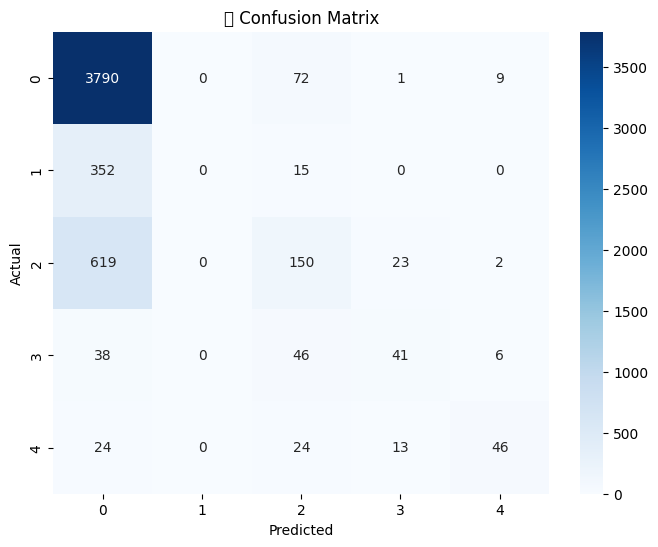

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model and calculate advanced metrics
def evaluate_metrics(model, loader, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification Report
    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("🧾 Confusion Matrix")
    plt.show()

# Class names (according to the folder order inside ImageFolder)
class_names = train_data.classes  # Or set manually: ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]

# Run evaluation on the test_loader
evaluate_metrics(model, test_loader, class_names=class_names)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
<ipython-input-5-34da2658bcab>:55: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap, 0)


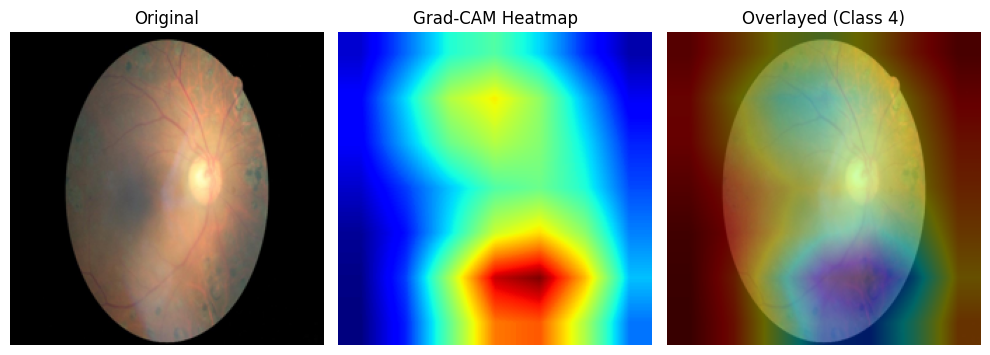

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import torch.nn.functional as F

# Ensure the model is in evaluation mode
model.eval()

# Target layer (usually the last CNN layer before the FC)
target_layer = model.layer4[2].conv2

# Class to apply Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax().item()

        target = output[0, class_idx]
        target.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]

        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=0).cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)
        return heatmap.numpy(), class_idx

# Choose an image from test set 4
image_path = '/content/retinopathy_dataset/4/10017_right.jpeg'  # Change the path according to your image
img = Image.open(image_path).convert('RGB')

# Apply the same transform used for testing
input_tensor = test_val_transform(img).unsqueeze(0).to(device)

# Grad-CAM
gradcam = GradCAM(model, target_layer)
heatmap, pred_class = gradcam.generate(input_tensor)

# Display results
img_np = np.array(img.resize((224, 224)))
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_np, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis('off')

plt.subplot(1,3,3)
plt.title(f"Overlayed (Class {pred_class})")
plt.imshow(superimposed_img)
plt.axis('off')

plt.tight_layout()
plt.show()

gradcam.remove_hooks()


<ipython-input-6-195ff79b716c>:55: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap, 0)


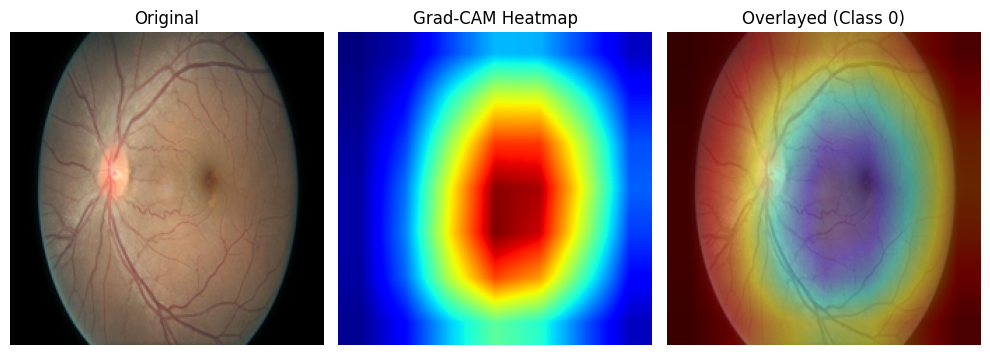

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import torch.nn.functional as F

# Ensure the model is in evaluation mode
model.eval()

# Target layer (usually the last CNN layer before the FC)
target_layer = model.layer4[2].conv2

# Class to apply Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax().item()

        target = output[0, class_idx]
        target.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]

        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=0).cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)
        return heatmap.numpy(), class_idx

# Choose an image from test set 0
image_path = '/content/retinopathy_dataset/0/10009_right.jpeg'  # Change the path according to your image
img = Image.open(image_path).convert('RGB')

# Apply the same transform used for testing
input_tensor = test_val_transform(img).unsqueeze(0).to(device)

# Grad-CAM
gradcam = GradCAM(model, target_layer)
heatmap, pred_class = gradcam.generate(input_tensor)

# Display the result
img_np = np.array(img.resize((224, 224)))
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_np, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis('off')

plt.subplot(1,3,3)
plt.title(f"Overlayed (Class {pred_class})")
plt.imshow(superimposed_img)
plt.axis('off')

plt.tight_layout()
plt.show()

gradcam.remove_hooks()


<ipython-input-7-103cf94d348e>:55: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap, 0)


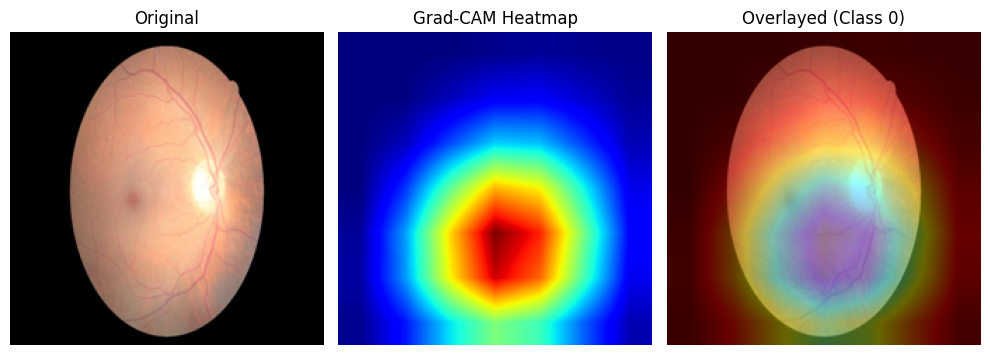

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import torch.nn.functional as F

# Ensure the model is in evaluation mode
model.eval()

# Target layer (usually the last CNN layer before the FC)
target_layer = model.layer4[2].conv2

# Class to apply Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax().item()

        target = output[0, class_idx]
        target.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]

        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=0).cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)
        return heatmap.numpy(), class_idx

# Choose an image from test set 1
image_path = '/content/retinopathy_dataset/1/10169_right.jpeg'  # Change the path according to your image
img = Image.open(image_path).convert('RGB')

# Apply the same transform used for testing
input_tensor = test_val_transform(img).unsqueeze(0).to(device)

# Grad-CAM
gradcam = GradCAM(model, target_layer)
heatmap, pred_class = gradcam.generate(input_tensor)

# Display the result
img_np = np.array(img.resize((224, 224)))
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_np, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis('off')

plt.subplot(1,3,3)
plt.title(f"Overlayed (Class {pred_class})")
plt.imshow(superimposed_img)
plt.axis('off')

plt.tight_layout()
plt.show()

gradcam.remove_hooks()


In [ ]:
!pip install captum


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Convergence Delta: -0.0534


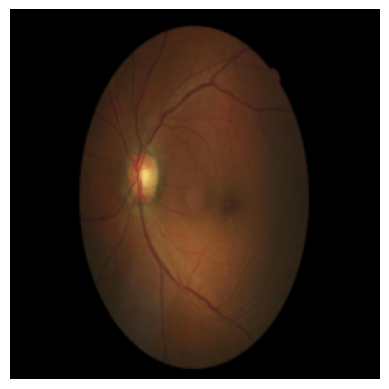

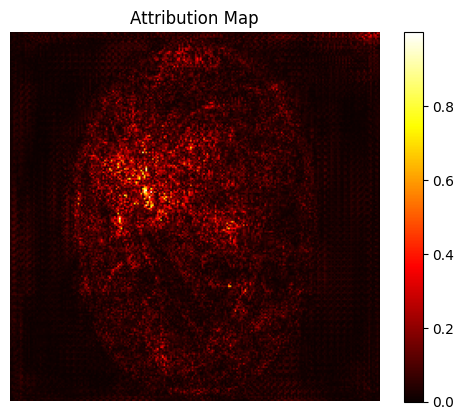

In [ ]:
# 1. Import Required Libraries
import torch
from torchvision import datasets, transforms
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np
import random

# 2. Set Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Load the Pretrained Model (Replace this with your own model if needed)
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 5)  # Adjusted for 5 classes
model = model.to(device)
model.eval()

# 4. Define Image Transformations (Same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 5. Load Test Dataset
test_dataset = datasets.ImageFolder(
    '/content/retinopathy_split/test',  # Change the path to your test data
    transform=transform
)

# 6. Function to Show the Original Image
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Reverse normalization
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# 7. Function to Visualize Attribution Map
def visualize_attr(attr):
    attr = attr.cpu().detach().numpy()

    # Handle different shapes
    if attr.ndim == 4:
        attr = attr.squeeze(0)
    if attr.ndim == 3 and attr.shape[0] == 1:
        attr = attr.squeeze(0)
    elif attr.ndim == 3 and attr.shape[0] == 3:
        attr = attr.transpose(1, 2, 0)
        attr = np.sum(np.abs(attr), axis=2)
    elif attr.ndim == 2:
        pass
    else:
        raise ValueError(f"Unexpected shape: {attr.shape}")

    # Normalize values to [0, 1]
    attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)

    # Plot the heatmap
    plt.imshow(attr, cmap='hot')
    plt.colorbar()
    plt.axis('off')
    plt.title('Attribution Map')
    plt.show()

# 8. Select a Random Sample from Test Dataset
idx = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[idx]
image = image.to(device)
label = torch.tensor(label).to(device)

# 9. Compute Integrated Gradients Attribution
ig = IntegratedGradients(model)
attributions, delta = ig.attribute(
    inputs=image.unsqueeze(0),
    target=label,
    return_convergence_delta=True
)

# 10. Display Results
print(f"Convergence Delta: {delta.item():.4f}")
show_image(image)
visualize_attr(attributions)
